## Simple NBA Elo Ratings

In this post, we will build a very simple example of the [Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system) and apply it to rate NBA teams. We will look at the key assumptions and math behind Elo ratings, and show you how to implement the system in Python.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', palette='colorblind')

In [3]:
import math
import operator
from collections import OrderedDict
from enum import Enum

We will use the [`pracnbastats`](https://pypi.org/project/pracnbastats/) package I developed for scraping [stats.nba.com](http://stats.nba.com/). You can install this package in your sports analytics Python environment by executing `pip install pracnbastats` in Terminal or at the Anaconda Prompt in Windows.

In [4]:
import pracnbastats as nba

In [5]:
from pathlib import Path

This code assumes the existence of a directory to hold scraped NBA data. You can create and name this directory however you want, and adjust the code in the cell below to suit your preferences.

In [6]:
PROJECT_DIR = Path.cwd().parent
DATA_DIR = PROJECT_DIR / 'data' / 'stats-nba-com'

In [7]:
filehandler = nba.FileHandler(DATA_DIR)

### Scraping NBA 2017-18 Regular Season Match Ups

First, we will get a list of all the current NBA teams. We will need to use this as a lookup table to get the [stats.nba.com](http://stats.nba.com/) team ID.

In [8]:
nba.currentteams.load(filehandler)
teams = nba.currentteams.data()
teams

,id,abbr,code,conference,division,city,name,since
0,1610612738,BOS,celtics,East,Atlantic,Boston,Celtics,1946
1,1610612752,NYK,knicks,East,Atlantic,New York,Knicks,1946
2,1610612751,BKN,nets,East,Atlantic,Brooklyn,Nets,1976
3,1610612761,TOR,raptors,East,Atlantic,Toronto,Raptors,1995
4,1610612755,PHI,sixers,East,Atlantic,Philadelphia,76ers,1949
5,1610612749,MIL,bucks,East,Central,Milwaukee,Bucks,1968
6,1610612741,CHI,bulls,East,Central,Chicago,Bulls,1966
7,1610612739,CLE,cavaliers,East,Central,Cleveland,Cavaliers,1970
8,1610612754,IND,pacers,East,Central,Indiana,Pacers,1976
9,1610612765,DET,pistons,East,Central,Detroit,Pistons,1948


Now, let's get all of the team box scores for the 2017-18 regular season.

In [9]:
nba1718 = nba.team.BoxScores(filehandler=filehandler)
nba1718.data.shape

(2460, 30)

In [10]:
nba1718.data.head()

,season,season_type,team_id,team_abbr,game_id,date,opp_team_abbr,home_road,win_loss,min,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,mov,video
0,2017,reg,1610612757,POR,21701229,2018-04-11,UTA,H,W,240,41,89,0.461,9,24,0.375,11,16,0.688,7,39,46,19,9,9,10,22,102,9,Y
1,2017,reg,1610612762,UTA,21701229,2018-04-11,POR,R,L,240,33,89,0.371,8,23,0.348,19,24,0.792,14,39,53,18,5,7,15,19,93,-9,Y
2,2017,reg,1610612746,LAC,21701228,2018-04-11,LAL,H,L,240,41,83,0.494,6,18,0.333,12,28,0.429,8,33,41,27,8,1,17,17,100,-15,Y
3,2017,reg,1610612747,LAL,21701228,2018-04-11,LAC,R,W,240,42,88,0.477,17,39,0.436,14,16,0.875,10,39,49,25,8,6,17,23,115,15,Y
4,2017,reg,1610612758,SAC,21701230,2018-04-11,HOU,H,W,240,38,80,0.475,7,26,0.269,13,20,0.650,6,42,48,22,6,3,11,14,96,13,Y


To compute Elo ratings, what we really need is the match up information. This view of the data combines the home and road team information on one row per game.

In [11]:
nba1718.matchups.head()

,game_id,season,season_type,date,team_id_h,team_abbr_h,pts_h,win_loss_h,team_id_r,team_abbr_r,pts_r,win_loss_r,hr_winner,winner,loser,mov
0,21701229,2017,reg,2018-04-11,1610612757,POR,102,W,1610612762,UTA,93,L,H,POR,UTA,9
1,21701228,2017,reg,2018-04-11,1610612746,LAC,100,L,1610612747,LAL,115,W,R,LAL,LAC,15
2,21701230,2017,reg,2018-04-11,1610612758,SAC,96,W,1610612745,HOU,83,L,H,SAC,HOU,13
3,21701221,2017,reg,2018-04-11,1610612748,MIA,116,W,1610612761,TOR,109,L,H,MIA,TOR,7
4,21701225,2017,reg,2018-04-11,1610612750,MIN,112,W,1610612743,DEN,106,L,H,MIN,DEN,6


In [12]:
nba1718.matchups.shape

(1230, 16)

Here's a summary of all 30 NBA teams' regular season records, broken out by home and road games.

In [13]:
nba1718.team_records

,team_abbr,season,season_type,team_id,games,wins,losses,home,road,home_wins,home_losses,road_wins,road_losses,win_pct,home_win_pct,road_win_pct
0,POR,2017,reg,1610612757,82,49,33,41,41,28,13,21,20,0.597561,0.682927,0.512195
1,LAC,2017,reg,1610612746,82,42,40,41,41,22,19,20,21,0.512195,0.536585,0.487805
2,SAC,2017,reg,1610612758,82,27,55,41,41,14,27,13,28,0.329268,0.341463,0.317073
3,MIA,2017,reg,1610612748,82,44,38,41,41,26,15,18,23,0.536585,0.634146,0.439024
4,MIN,2017,reg,1610612750,82,47,35,41,41,30,11,17,24,0.573171,0.731707,0.414634
5,ORL,2017,reg,1610612753,82,25,57,41,41,17,24,8,33,0.304878,0.414634,0.195122
6,PHI,2017,reg,1610612755,82,52,30,41,41,30,11,22,19,0.634146,0.731707,0.536585
7,OKC,2017,reg,1610612760,82,48,34,41,41,27,14,21,20,0.585366,0.658537,0.512195
8,NOP,2017,reg,1610612740,82,48,34,41,41,24,17,24,17,0.585366,0.585366,0.585366
9,CHI,2017,reg,1610612741,82,27,55,41,41,17,24,10,31,0.329268,0.414634,0.243902


### Simple Elo Ratings

Now we are ready to implement the simple Elo system as described in [this post](http://practicallypredictable.com/2018/04/15/elo-ratings-for-nba-teams/).

The Elo home team win probability formula is:

$$P(\textrm{Home team wins}) = \frac{1}{1 + 10^{-\frac{(H-R+A)}{400}}}$$

The win probability for the road team is just $1 - P(\textrm{Home team wins})$.

The function below computes the win probabilities for both the home and road teams. The function takes a parameter defining the value of home court, expressed in units of Elo rating points. As described in the main post, this function actually uses the more convenient Elo formula in terms of odds:

$$P(\textrm{Home team wins}) = \frac{ah}{r + ah}$$
and
$$P(\textrm{Road team wins}) = \frac{r}{r + ah}$$
where
$$h = 10^{\frac{H}{400}} \\ r = 10^{\frac{R}{400}} \\ a = 10^{\frac{A}{400}}$$

In [14]:
def win_probs(*, home_elo, road_elo, hca_elo):
    """Home and road team win probabilities implied by Elo ratings and home court adjustment."""
    h = math.pow(10, home_elo/400)
    r = math.pow(10, road_elo/400)
    a = math.pow(10, hca_elo/400)
    denom = r + a*h
    home_prob = a*h / denom
    road_prob = r / denom
    return home_prob, road_prob

We will also look at Elo ratings in terms of odds. This function computes the odds on the home team. The odds on the road team are just the reciprocal of the home team odds.

In [15]:
def home_odds_on(*, home_elo, road_elo, hca_elo):
    """Odds in favor of home team implied by Elo ratings and home court adjustment."""
    h = math.pow(10, home_elo/400)
    r = math.pow(10, road_elo/400)
    a = math.pow(10, hca_elo/400)
    return a*h/r

Let's test our our functions, and examine some basic properties of the Elo ratings system.

If two teams have the same Elo ratings, and there is no home court advantage, the win probabilit should be 50%.

In [16]:
win_probs(home_elo=1500, road_elo=1500, hca_elo=0)

(0.5, 0.5)

This is the same as saying that the odds on a team winning are 1:1.

In [17]:
home_odds_on(home_elo=1500, road_elo=1500, hca_elo=0)

1.0

Using the standard Elo scaling parameters, a 400 point ratings differential in favor of the home team should multiply the odds on the home team winning by 10.

In [18]:
home_odds_on(home_elo=1900, road_elo=1500, hca_elo=0)

10.0

Expressing this shift in the odds in terms of probability, we see that the home team win probabilty is now almost 91%.

In [19]:
win_probs(home_elo=1900, road_elo=1500, hca_elo=0)

(0.9090909090909091, 0.09090909090909091)

Only the difference in the ratings matter for the Elo system. For example, 2000 versus 1600 is the same as 1900 versus 1500.

In [20]:
home_odds_on(home_elo=2000, road_elo=1600, hca_elo=0)

10.0

In [21]:
win_probs(home_elo=2000, road_elo=1600, hca_elo=0)

(0.9090909090909091, 0.09090909090909091)

A 400 point ratings differential in the other direction (in favor of the road team) divides the odds on the home team winning by 10.

In [22]:
home_odds_on(home_elo=1100, road_elo=1500, hca_elo=0)

0.09999999999999999

Now the road team has a probabilty of almost 91% of winning the game.

In [23]:
win_probs(home_elo=1100, road_elo=1500, hca_elo=0)

(0.0909090909090909, 0.9090909090909091)

### Plotting the Elo Ratings Logistic Function

The probability assumptions used in the Elo rating system mean that the win probabilities are computed using a version of the [logistic function](https://en.wikipedia.org/wiki/Logistic_function).

Let's see what this function looks like for the specific parameters used in Elo ratings. The plot below doesn't include any adjustment for home court advantage.

In [24]:
x = np.linspace(-1200, 1200, 240)
x.shape

(240,)

In [25]:
vec_win_probs = np.vectorize(win_probs)

In [26]:
y = vec_win_probs(home_elo=x, road_elo=0, hca_elo=0)[0]
y.shape

(240,)

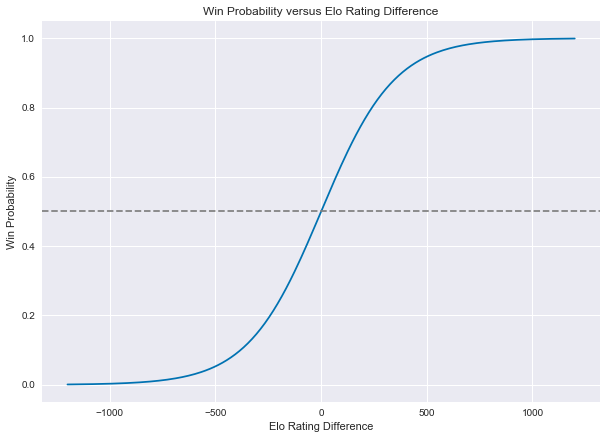

In [27]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(x, y)
ax.set_xlabel('Elo Rating Difference')
ax.set_ylabel('Win Probability')
ax.set_title('Win Probability versus Elo Rating Difference')
ax.axhline(y=0.5, linestyle='dashed', color='grey')
plt.show()

### Home Court Advantage

Now let's estimate the parameter to use to adjust for home court advantage. As described in [this post](http://practicallypredictable.com/2018/01/09/first-look-nba-home-court-advantage/), the average NBA home team win percentage since the 1996-97 season has been roughly 59.8%. We can calibrate our adjustment parameter to this historical value.

In [28]:
def hca_calibrate(*, home_win_prob):
    """Calibrate Elo home court adjustment to a given historical home team win percentage."""
    if home_win_prob <= 0 or home_win_prob >= 1:
        raise ValueError('invalid home win probability', home_win_prob)
    a = home_win_prob / (1 - home_win_prob)
    print(f'a = {a}')
    hca = 400 * math.log10(a)
    return hca

In [29]:
hca_elo = hca_calibrate(home_win_prob=0.598)
hca_elo

a = 1.4875621890547261


68.99005236157628

We will use a home court adjustment of 69 simple Elo rating points to analyze NBA teams.

Here is a modifed plot of the Elo logistic function with and without home court advantage adjustment. Note how the adjustment shifts the curve so that an Elo rating differential of 69 points in favor of the road team is a 50-50 match up. Equivalently, for an Elo rating differential of zero, the home team win probabilty is 59.8%.

In [30]:
hca_y = vec_win_probs(home_elo=x, road_elo=0, hca_elo=hca_elo)[0]

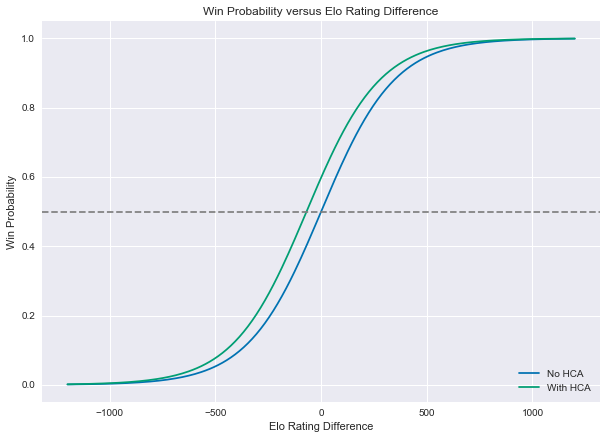

In [31]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(x, y, label='No HCA')
ax.plot(x, hca_y, label='With HCA')
ax.set_xlabel('Elo Rating Difference')
ax.set_ylabel('Win Probability')
ax.set_title('Win Probability versus Elo Rating Difference')
ax.axhline(y=0.5, linestyle='dashed', color='grey')
ax.legend(loc='lower right')
plt.show()

### Computing the Team Elo Ratings

Now we can compute Elo ratings for all 30 NBA teams over the course of the 2017-18 regular season. A detailed discussion of the assumptions and math behind Elo ratings is included in [this post](http://practicallypredictable.com/2018/04/15/elo-ratings-for-nba-teams/).

#### Elo Ratings Update

The method is very simple. First, we need a function to update the Elo ratings, based upon the prior ratings, the adjustment for home court advantage, and which team won the game. We need to specify the parameter $K$, which controls how much to adjust the Elo ratings for each game. We will use the value $K = 20$ in this notebook.

Here are the formulas used to update Elo ratings:

$$H_{new} = H_{prior} + K \times (W_H - p_H)$$

$$R_{new} = R_{prior} + K \times (W_R - p_R)$$

The $W$ variables are 1 depending upon whether the home or road team won. Notice that $W_R = 1 - W_H$ since a win by one team is a loss by the other.

The $p$ variables are the Elo win probabilities for the home and road team, computed using the function above. Notice that $p_R = 1 - p_H$ since there are no ties in basketball.

In [32]:
def update(*, winner, home_elo, road_elo, hca_elo, k, probs=False):
    """Update Elo ratings for a given match up."""
    home_prob, road_prob = win_probs(home_elo=home_elo, road_elo=road_elo, hca_elo=hca_elo)
    if winner[0].upper() == 'H':
        home_win = 1
        road_win = 0
    elif winner[0].upper() in ['R', 'A', 'V']: # road, away or visitor are treated as synonyms
        home_win = 0
        road_win = 1
    else:
        raise ValueError('unrecognized winner string', winner)
    new_home_elo = home_elo + k*(home_win - home_prob)
    new_road_elo = road_elo + k*(road_win - road_prob)
    if probs:
        return new_home_elo, new_road_elo, home_prob, road_prob
    else:
        return new_home_elo, new_road_elo

Let's test out our Elo update function for various situations. If the home and road team are equally matched and there is no home court advantage, the winner's Elo rating goes up by 10 points, and the loser drops by 10 points. Elo ratings are zero-sum, since the loser gives up points to the winner.

In [33]:
update(winner='H', home_elo=1500, road_elo=1500, hca_elo=0, k=20)

(1510.0, 1490.0)

In [34]:
update(winner='R', home_elo=1500, road_elo=1500, hca_elo=0, k=20)

(1490.0, 1510.0)

Now, let's add in a home court advantage. This shifts the win probabilities.

In [35]:
update(winner='H', home_elo=1500, road_elo=1500, hca_elo=hca_elo, k=20)

(1508.04, 1491.96)

In [36]:
update(winner='R', home_elo=1500, road_elo=1500, hca_elo=hca_elo, k=20)

(1488.04, 1511.96)

The teams are still equally rated, but now we see that the home team is the slight favorite. When the road team wins, it's Elo rating afterwards is almost 1512. Compare that to the 1508 updated Elo rating the home team would have gotten if it had won.

#### Computing Elo Ratings for the Whole Season

In our simple Elo rating system, we will set all teams to an average rating of 1500 at the beginning of the season. In future posts, we will examine ways to extend the system to incorporate information across seasons. Doing this properly requires some thought around roster and coaching changes.

Setting all teams to an initial 1500 rating means that we start off knowing nothing about the teams. By the end of the regular season, hopefully our ratings system will have learned enough about team strength to make useful playoff predictions.

The below function computes the Elo ratings over an entire NBA regular season. The function is long, but not very complicated. Here is an outline of what it does:

1. Set all the initial team ratings to 1500
2. Get the match up results and sort them in chronological order
3. Loop through all game results:
    - Get the Elo ratings from the home and road teams prior to the game
    - Figure out which team won the game
    - Get the new Elo ratings based on who won the game and home court advantage
    - Store the before and after Elo ratings and the date of the game so we can plot time series charts later
    - Store the new Elo ratings
4. At the end, check for data consistentcy
5. Return the end-of-season Elo ratings and a time series of Elo ratings for all the teams, along with the match up information used to compute the ratings

In [37]:
def simple_nba_elo(*, box_scores, teams, hca_elo, k):
    """Compute simple Elo ratings over the course of an NBA season."""
    latest_elos = {abbr: 1500 for abbr in teams['abbr']}
    matchups = box_scores.matchups.sort_values(by='date', ascending=True).copy()
    home_probs = []
    road_probs = []
    home_elos = []
    road_elos = []
    index_check = []
    elo_ts = []
    for game in matchups.itertuples(index=True):
        index = game.Index
        home_team = game.team_abbr_h
        road_team = game.team_abbr_r
        winner = game.hr_winner
        home_elo = latest_elos[home_team]
        road_elo = latest_elos[road_team]
        (new_home_elo, new_road_elo, home_prob, road_prob) = update(
            winner=winner,
            home_elo=home_elo,
            road_elo=road_elo,
            hca_elo=hca_elo,
            k=k,
            probs=True
        )
        home_info = OrderedDict({
            'date': game.date,
            'game_id': game.game_id,
            'abbr': home_team,
            'matchup_index': index,
            'opp_abbr': road_team,
            'home_road': 'H',
            'win_loss': 'W' if winner == 'H' else 'L',
            'win_prob': home_prob,
            'opp_prior_elo': latest_elos[road_team],
            'prior_elo': latest_elos[home_team],
            'new_elo': new_home_elo,
        })
        elo_ts.append(home_info)
        road_info = OrderedDict({
            'date': game.date,
            'game_id': game.game_id,
            'abbr': road_team,
            'matchup_index': index,
            'opp_abbr': home_team,
            'home_road': 'R',
            'win_loss': 'W' if winner == 'R' else 'L',
            'win_prob': road_prob,
            'opp_prior_elo': latest_elos[home_team],
            'prior_elo': latest_elos[road_team],
            'new_elo': new_road_elo,
        })
        elo_ts.append(road_info)
        latest_elos[home_team] = new_home_elo
        latest_elos[road_team] = new_road_elo
        home_probs.append(home_prob)
        road_probs.append(road_prob)
        home_elos.append(new_home_elo)
        road_elos.append(new_road_elo)
        index_check.append(index)
    matchups['home_prob'] = home_probs
    matchups['road_prob'] = road_probs
    matchups['home_elos'] = home_elos
    matchups['road_elos'] = road_elos
    matchups['index_check'] = index_check
    if not all(matchups['index_check'] == matchups.index):
        raise RuntimeError('indices do not match!')
    matchups = matchups.drop(columns=['index_check'])
    return matchups, pd.DataFrame(elo_ts), latest_elos

Let's run the function to get the 2017-18 Elo ratings for all 30 NBA teams. As discussed above, we are using a home court advantage adjustment of 69 Elo rating points and a $K$ value of 20.

In [38]:
matchups, elo_hist, curr_elos = simple_nba_elo(box_scores=nba1718, teams=teams, hca_elo=hca_elo, k=20)

### The Results, and Some Plots

Here are the Elo ratings for all 30 NBA teams as of the end of the regular season, ranked best to worst.

In [39]:
sorted(curr_elos.items(), key=operator.itemgetter(1), reverse=True)

[('HOU', 1718.7573739310872),
 ('TOR', 1642.509234000021),
 ('PHI', 1637.8605055619669),
 ('UTA', 1616.2033964377317),
 ('POR', 1595.065188211564),
 ('GSW', 1590.3946390420315),
 ('NOP', 1587.2519843938655),
 ('BOS', 1586.1753617623024),
 ('IND', 1584.6564274796217),
 ('OKC', 1580.234680473253),
 ('CLE', 1570.556557419121),
 ('DEN', 1568.7112357272322),
 ('SAS', 1541.9814371909993),
 ('MIN', 1540.460835899911),
 ('MIL', 1521.473057845756),
 ('LAC', 1512.9777428218233),
 ('MIA', 1512.1543637174311),
 ('WAS', 1484.998604454014),
 ('DET', 1467.7427511888648),
 ('LAL', 1461.962359042527),
 ('CHA', 1460.0431212254493),
 ('BKN', 1403.3122168209793),
 ('SAC', 1392.8896638705985),
 ('ATL', 1374.0186175508284),
 ('NYK', 1367.6683600631823),
 ('CHI', 1365.4361876958365),
 ('DAL', 1351.5809302667749),
 ('ORL', 1344.7360522769086),
 ('MEM', 1314.910648773433),
 ('PHX', 1303.2764648548855)]

Notice that since Elo ratings are zero-sum, the league average at the end of the season is the same as at the start of season.

In [40]:
sum(elo for elo in curr_elos.values()) / len(curr_elos)

1499.9999999999998

(The reason the average isn't exactly 1500 is due to small numerical round-off errors during all these calculations.)

One of the results of the function is a time series of the Elo ratings by date and team.

In [41]:
elo_hist.tail(20)

,date,game_id,abbr,matchup_index,opp_abbr,home_road,win_loss,win_prob,opp_prior_elo,prior_elo,new_elo
2440,2018-04-11,21701221,MIA,3,TOR,H,W,0.378393,1654.941373,1499.722224,1512.154364
2441,2018-04-11,21701221,TOR,3,MIA,R,L,0.621607,1499.722224,1654.941373,1642.509234
2442,2018-04-11,21701225,MIN,4,DEN,H,W,0.531625,1578.078736,1531.093335,1540.460836
2443,2018-04-11,21701225,DEN,4,MIN,R,L,0.468375,1531.093335,1578.078736,1568.711236
2444,2018-04-11,21701222,ORL,5,WAS,H,W,0.364324,1497.712134,1332.022523,1344.736052
2445,2018-04-11,21701222,WAS,5,ORL,R,L,0.635676,1332.022523,1497.712134,1484.998604
2446,2018-04-11,21701220,CLE,10,NYK,H,L,0.853405,1350.600259,1587.624658,1570.556557
2447,2018-04-11,21701220,NYK,10,CLE,R,W,0.146595,1587.624658,1350.600259,1367.668360
2448,2018-04-11,21701227,OKC,7,MEM,H,W,0.869252,1317.525610,1577.619719,1580.234680
2449,2018-04-11,21701227,MEM,7,OKC,R,L,0.130748,1577.619719,1317.525610,1314.910649


We can use this time series data to plot the path of teams' Elo ratings over the course of the season.

In [42]:
def plot_elo(*, data, team, ax):
    ts = data.loc[data['abbr'] == team, ['date', 'new_elo']].set_index(['date'])
    ts = ts.rename(columns={'new_elo': team})
    ts.plot(ax=ax, label=team)
    return ax

In [43]:
def plot_elo_for_teams(*, data, teams):
    fig, ax = plt.subplots(figsize=(10, 7))
    for team in teams:
        ax = plot_elo(data=elo_hist, team=team, ax=ax)
    plt.show()

Here is a plot of the Elo ratings for all six of the NBA division winners.

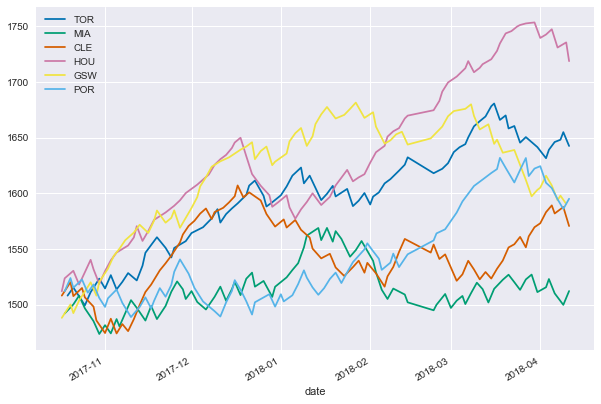

In [44]:
plot_elo_for_teams(data=elo_hist, teams=['TOR', 'MIA', 'CLE', 'HOU', 'GSW', 'POR',])

Here are the Elo ratings for the 4 teams in the Eastern Conference middle playoff brackets.

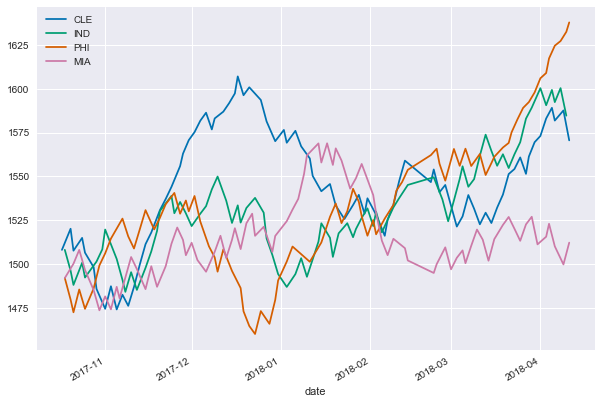

In [45]:
plot_elo_for_teams(data=elo_hist, teams=['CLE', 'IND', 'PHI', 'MIA',])

Here is a similar plot for the 4 teams in the Western Conference middle playoff brackets.

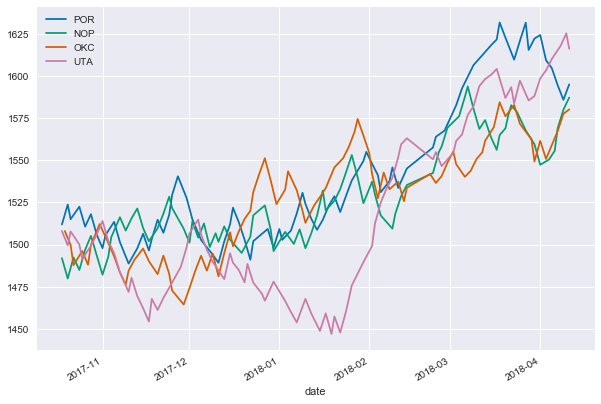

In [46]:
plot_elo_for_teams(data=elo_hist, teams=['POR', 'NOP', 'OKC', 'UTA',])